In [1]:
# imports and configuration

# uncomment to use a custom environment file
# from dotenv import load_dotenv
# load_dotenv('../main.env')

import os
from pathlib import Path

MODELS_PATH = Path(os.getenv('MODELS_PATH'))
DATA_PATH = Path(os.getenv('DATA_PATH'))
TORCH_HOME = Path(os.getenv('TORCH_HOME'))

print(f'{MODELS_PATH=}')
print(f'{DATA_PATH=}')
print(f'{TORCH_HOME=}')

import matplotlib.pyplot as plt
import random

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms.v2 as transforms
import torchvision.utils as vutils
from torchvision.datasets import CIFAR10

from introdl.utils import get_device, load_results, create_CIFAR10_loaders
from introdl.idlmam import train_network
from introdl.visul import plot_training_metrics, plot_transformed_images

from sklearn.metrics import accuracy_score

MODELS_PATH=WindowsPath('C:/Users/bagge/My Drive/Python_Projects/DS776_Develop_Project/models')
DATA_PATH=WindowsPath('C:/Users/bagge/My Drive/Python_Projects/DS776_Develop_Project/data')
TORCH_HOME=WindowsPath('C:/Users/bagge/My Drive/Python_Projects/DS776_Develop_Project/downloads')


# Data Augmentation for training our CIFAR-10 Classifiers

In this notebook we'll apply data augmentation to our training pipeline for training SimpleCNN on the CIFAR-10 dataset. 

Here's our model class from the previous notebook.


In [2]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)
        
    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

Here is the plot of the training metrics when we used `AdamW` with `lr=0.001` and `weight_decay=0.5`.  This is just to remind us of how well the training went before using data augmentation.

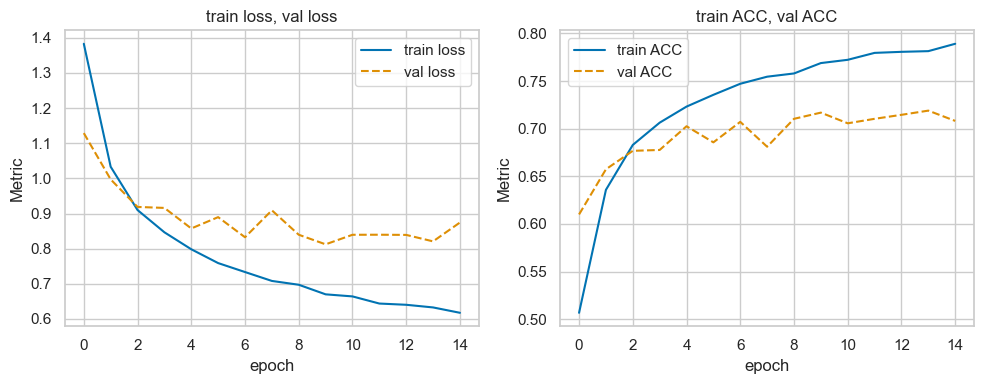

In [3]:
ckpt_file = MODELS_PATH / 'L03_CIFAR10_SimpleCNN_AdamW_wd.pt'
results = load_results(ckpt_file)

plot_training_metrics(results, [['train loss', 'val loss'], ['train ACC', 'val ACC']])

While we're getting about 70% accuracy on the validation set, but we're seeing evidence of fairly strong overfitting.  As we'll see below, using data augmentation can both increase the model performance and decrease the overfitting.

## Data Augmentation

Deep learning models are data-hungry, and one way to increase the amount of data available for training is to augment the data. Data augmentation is a technique used to increase the diversity of the training data by applying random transformations to the input data. This can help the model generalize better to unseen data and reduce overfitting.

When choosing transforms for data augmentation, the goal is to increase the diversity of the training data while preserving the integrity of the original images. Here are some general guidelines to consider:

1. **Random Flips**: Randomly flipping images horizontally or vertically can help the model learn to recognize objects from different perspectives. This is particularly useful for tasks where object orientation is not important.

2. **Random Rotations**: Applying random rotations to the images can help the model become more robust to variations in object orientation. However, be cautious with large rotation angles, as they may introduce unrealistic distortions.

3. **Color Jittering**: Randomly adjusting the brightness, contrast, saturation, and hue of the images can introduce variations in lighting conditions. This can help the model generalize better to different lighting conditions in real-world scenarios.

4. **Random Grayscale**: Converting images to grayscale randomly can help the model focus on texture and shape rather than color. This can be useful when color is not a significant factor in the task.

5. **Random Crop**: Randomly cropping a portion of the image can simulate different viewpoints or zoom levels of the same object. This helps the model become more translation-invariant and improves its ability to recognize objects in different positions within the image.

6. **Resize and Padding**: Resizing images to a specific size and adding padding can ensure that all images have the same dimensions. This is important when working with models that require fixed input sizes.

7. **Normalization**: Applying normalization to the images can help the model converge faster during training. Normalization typically involves subtracting the mean and dividing by the standard deviation of the image dataset.

Remember to strike a balance between introducing enough variations to improve generalization and avoiding excessive distortions that may hinder the model's ability to learn meaningful patterns. It's also important to consider the specific requirements of your task and the characteristics of your dataset when choosing transforms for data augmentation.

Here's an example of including all those transformations in a pipeline for PyTorch:

In [4]:
mean = [0.4914, 0.4822, 0.4465] # stats for CIFAR10
std = [0.2023, 0.1994, 0.2010]

transform_train = transforms.Compose([
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomCrop(32, padding=4),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomGrayscale(p=0.2),
    transforms.Normalize(mean=mean, std=std),
    transforms.ToPureTensor()    
])

The flip transforms are applied with probability 0.5 and the grayscale transform we're applying with probabillity 0.2.  The rest of the transforms apply to every image with randomly selected values.  For example, the rotation transform will choose a random rotation between -15 degrees and 15 degrees.

Now let's create a CIFAR10 dataset with those transforms and plot some of the images.

In [5]:
dataset = CIFAR10(DATA_PATH, train=True, download=True, transform=transform_train)

Files already downloaded and verified


We'll use `plot_transformed_images` from `introdl.visul`.  It randomly chooses images and displays multiple copies.  Each time an image is loaded from the dataset the transformed image is different.  If you execute the cell below a few times you'll get different images and different transformed variations.

converting to uint8
[[[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  2   0   0]
  [  0   0   0]
  [ 12  11  10]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [ 13  13  14]
  [ 10   9   9]
  [  3   2   1]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [163 162 162]
  [136 133 132]
  [  5   6   5]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
converting to uint8
[[[ 14  14  14]
  [120 119 114]
  [125 123 119]
  ...
  [ 14  14  14]
  [ 14  14  14]
  [ 14  14  14]]

 [[ 14  14  14]
  [122 120 115]
  [125 123 119]
  ...
  [ 14  14  14]
  [ 14  14  14]
  [ 14  14  14]]

 [[ 14  14  14]
  [123 122 116]
  [122 122 117]
  ...
  [205 204 208]
  [ 14  14  14]
  [ 14  14  14]]

 ...

 [[ 14  14  

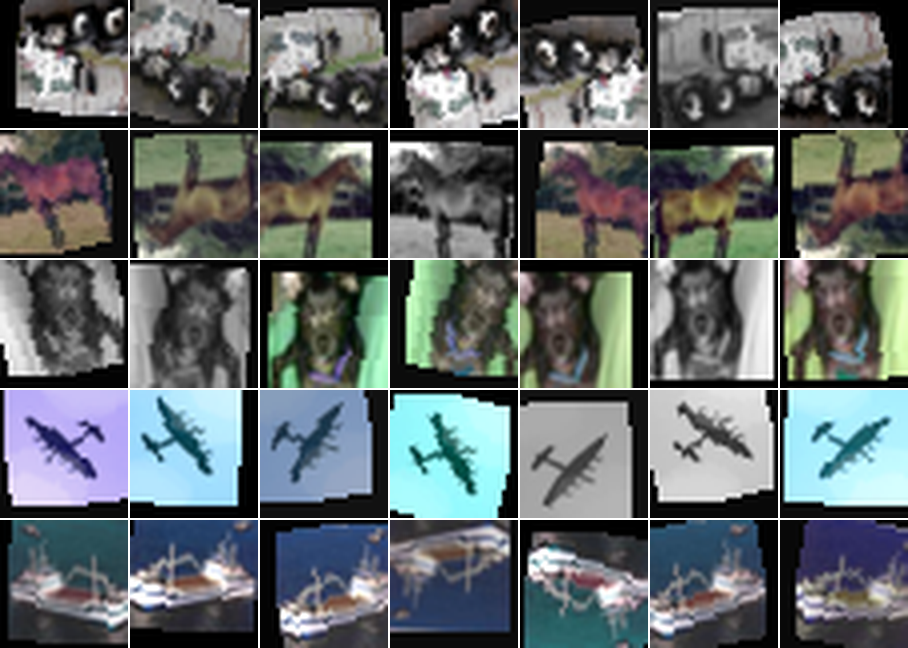

In [6]:
plot_transformed_images(dataset, num_images=5, num_transformed=6, img_size=(128,128),mean=mean, std=std)

When we choose the transformations that we'll actually use, it's important that the transforms produce realistic images and that they don't distort the images too much. That rules out vertical flips for this dataset since trucks and animals don't usually appear upside down. We'll also leave out rotation since that seems to really distort these low-resolution images.

We can use the same function to plot the transformed images, but this time we'll use the actual transformations that we'll use in the training process.

In [7]:
transform_train = transforms.Compose([
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomGrayscale(p=0.2),
    transforms.Normalize(mean=mean, std=std),
    transforms.ToPureTensor()    
])

dataset = CIFAR10(DATA_PATH, train=True, download=True, transform=transform_train)

Files already downloaded and verified


converting to uint8
[[[142 143 135]
  [140 142 133]
  [133 134 124]
  ...
  [126 126 118]
  [131 129 120]
  [  0   0   0]]

 [[153 153 148]
  [139 141 133]
  [142 142 131]
  ...
  [144 144 138]
  [147 146 140]
  [  0   0   0]]

 [[159 155 154]
  [147 144 142]
  [155 154 145]
  ...
  [157 158 151]
  [156 157 150]
  [  0   0   0]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
converting to uint8
[[[  5   5   5]
  [  5   5   5]
  [  5   5   5]
  ...
  [  5   5   5]
  [  5   5   5]
  [  5   5   5]]

 [[  5   5   5]
  [  5   5   5]
  [  5   5   5]
  ...
  [  5   5   5]
  [  5   5   5]
  [  5   5   5]]

 [[  5   5   5]
  [  5   5   5]
  [  5   5   5]
  ...
  [  5   5   5]
  [  5   5   5]
  [  5   5   5]]

 ...

 [[  5   5  

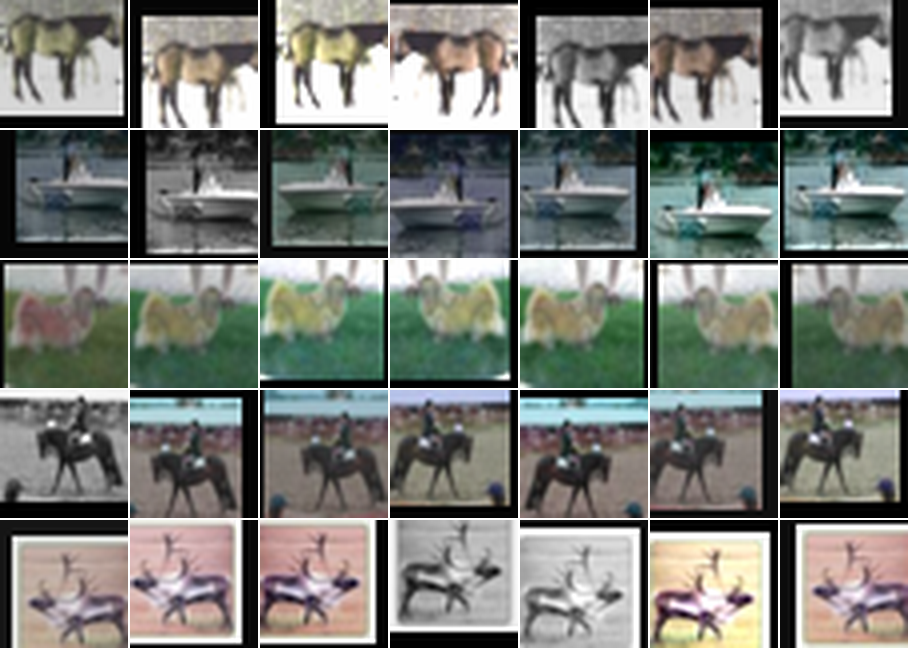

In [8]:
plot_transformed_images(dataset, num_images=5, num_transformed=6, img_size=(128,128),mean=mean, std=std)

Those transformed images look good so let's try training with that last set of transforms.  That set of transforms is alreaady build into our `create_CIFAR10_loaders` utility function.  We can use it as follows:

In [9]:
# create loaders with augmentation
train_loader, valid_loader, test_loader = create_CIFAR10_loaders(data_dir=DATA_PATH, 
                                                                 use_augmentation=True,
                                                                 num_workers=4)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


Initially we trained this model for 15 epochs, but since it was doing well we let it train for 30 epochs to see how well it could do.  

If you're experimenting with how long to train you can run for a few epochs, check your results, then run for more epochs.  There are two ways to resume training from a checkpoint file.  Both will run for however many *additional* epochs you specify.

1.  By adding `resume_checkpoint=True`.  If you do that, `train_network` will resume training from the specified checkpoint file and overwrite that file.
2.  If you don't want to overwrite your current checkpoint file, you can specify `resume_file={current checkpoint file}` and `checkpoint_file={next checkpoint file}`.  

In [10]:
model = SimpleCNN() # create a new instance of the model
loss_func = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters())  # default lr=0.001, weight_decay=0.01

device = get_device()
print(device)

ckpt_file = MODELS_PATH / 'L03_CIFAR10_SimpleCNN_AdamW_augment.pt'
epochs = 30

score_funcs = {'ACC':accuracy_score}

train_network(model,
    loss_func,
    train_loader,
    device=device,
    val_loader=valid_loader,
    epochs = epochs,
    optimizer = optimizer,
    score_funcs = {'ACC':accuracy_score},
    checkpoint_file = ckpt_file);

cuda


Epoch: 100%|██████████| 30/30 [03:56<00:00,  7.90s/it, train_loss=0.713, val_loss=0.697]


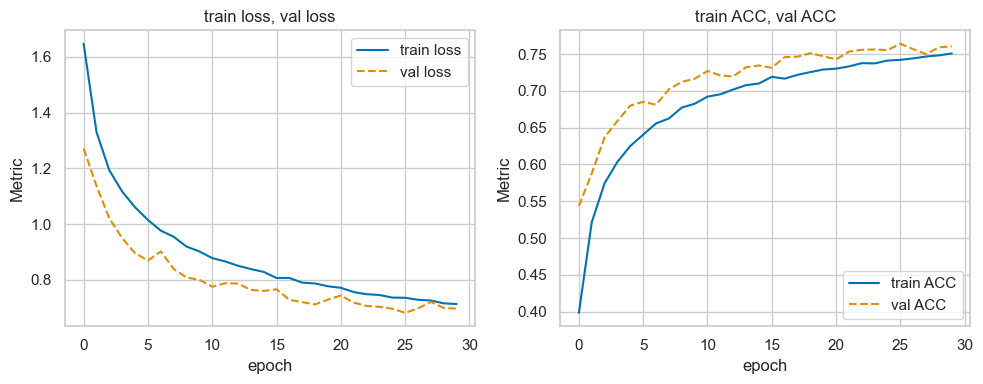

In [11]:
ckpt_file = MODELS_PATH / 'L03_CIFAR10_SimpleCNN_AdamW_augment.pt'
AdamW_augment = load_results(ckpt_file)

plot_training_metrics(AdamW_augment, [['train loss', 'val loss'], ['train ACC', 'val ACC']])

If we ran for long enough we might see some overfitting, but we can see that using data augmentation has both eliminated the overfitting to this point and increased the performance of the model. 

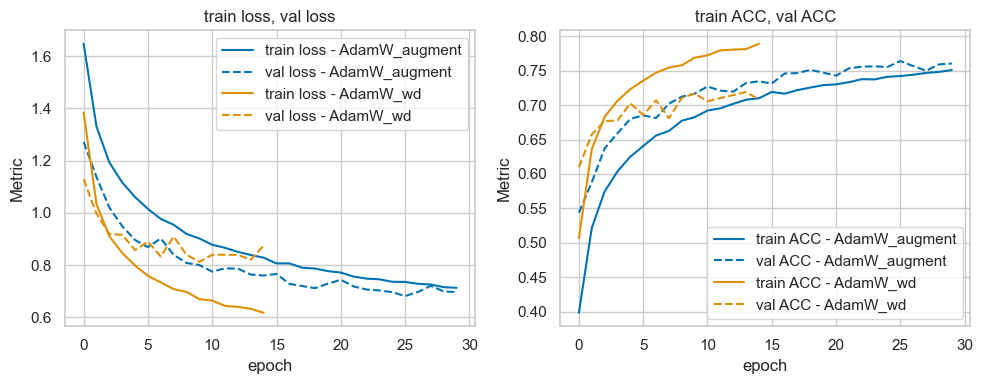

In [12]:
ckpt_file = MODELS_PATH / 'L03_CIFAR10_SimpleCNN_AdamW_augment.pt'
AdamW_augment = load_results(ckpt_file)

ckpt_file = MODELS_PATH / 'L03_CIFAR10_SimpleCNN_AdamW_wd.pt'
AdamW_wd = load_results(ckpt_file)

plot_training_metrics([AdamW_augment,AdamW_wd], 
                      [['train loss', 'val loss'], ['train ACC', 'val ACC']],
                      df_labels=['AdamW_augment', 'AdamW_wd'])

The picture is a bit cluttered, but note that using data augmentation both increases the performance of the model on the validation set and essentially eliminated overfitting!  That's impressive.  

If you ran the code in this notebook, you may have noticed that the training is significantly slower than without augmenation.  This is because the image processing required for the augmenation transformations occurs every time an instance is loaded and it's computing intensive.  PyTorch can use multiprocessing to employ multiple CPUs to load and process the images.  You can enable that in a DataLoader by setting num_workers = 2 or more (but not more than the number of available CPUs).  In our `create_CIFAR10_loaders` function you can set num_workers to a value greater than 1.  

Beware that this may not work if you're running Jupyter in a Windows environment.  PyTorch has improved its support for Windows in the past couple years, but if it doesn't work you may have to set num_workers to 1 in Windows.  Even if it works in Windows you may notice that the first epoch is quite slow compared to the rest because spawning additional processes in Windows is quite slow.